# Coherent error models


## basic calculation - naive fidelity of -Y/2 gate

Let's say we want to play an -Y/2 gate and we have an error of $\epsilon\ll 1$ so that our rotation axis is not $-\hat{y}$ but $-\sqrt{1-\epsilon^2}\hat{y} + \epsilon\hat{x}$. What is the error associated with this?

The unitary is: 

$$
U_e = \frac{1}{\sqrt{2}}I - i\frac{1}{\sqrt{2}}(\sqrt{1-\epsilon^2}\sigma_y + \epsilon\sigma_x)
$$

We want to calculate $F(|+>, U_e|0>) = |<+|U_e|0>|$. This is:

$$
U_e|0> = \frac{1}{\sqrt{2}}|0>+\frac{1}{\sqrt{2}}(\sqrt{1-\epsilon^2}|1>-i\epsilon|1>) \\
 \Rightarrow |<+|U_e|0>| = \frac{1}{2}|1 + \sqrt{1-\epsilon^2}-i\epsilon| \\
 = \sqrt{\frac{1}{2} + \frac{1}{2} \sqrt{1-\epsilon^2}} \\
 \simeq 1 -\frac{1}{8}\epsilon^2
$$

so we see that the error is of order $\epsilon^2$.

Let's verify this:

In [1]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline
plt.rcParams.update({'text.usetex': False})
from tqdm.notebook import tqdm

In [2]:

err_u = lambda epsilon: qp.qip.operations.rotation(np.sqrt(1-epsilon**2)*qp.sigmay()+qp.sigmax()*epsilon, 
            np.pi/2)


In [3]:
def fidelity_err(epsilon):
    return np.abs(((1/np.sqrt(2))*(qp.bra([0]) + qp.bra([1]))*err_u(epsilon)*qp.fock(2, 0))[0])

fidelity_err = np.vectorize(fidelity_err)

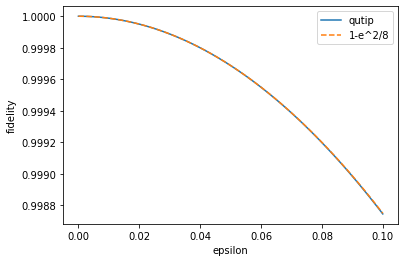

In [4]:

eps_vec = np.linspace(0, 0.1, 100)
plt.plot(eps_vec, fidelity_err(eps_vec), label='qutip')
plt.plot(eps_vec, 1-eps_vec**2/8, '--', label='1-e^2/8')
plt.xlabel('epsilon')
plt.ylabel('fidelity')
plt.legend()

## Simulation with qiskit

In [84]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb
import qiskit.quantum_info as qi

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error, coherent_unitary_error

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
from pprint import pprint
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import array_to_latex

## Measurement outcome calculation of a circuit with initial phase error

In [6]:
error_gates = {
    'x': qiskit.circuit.library.standard_gates.XGate(),
    'y': qiskit.circuit.library.standard_gates.YGate(),
    'h': qiskit.circuit.library.standard_gates.HGate(),
}


def qiskit_u_err_basic(epsilon, circ, err_qubit, nshots=10000):
    noise_model = NoiseModel()
    
    err_u = {}
    for gate in error_gates:
        err_c = QuantumCircuit(1)
        err_c.append(error_gates[gate].inverse(), [0])
        err_c.p(epsilon, 0)
        err_c.append(error_gates[gate], [0])
        err_c.p(-epsilon, 0)
        err_u[gate] = qi.Operator(err_c)
        noise_model.add_quantum_error(coherent_unitary_error(err_u[gate]), gate, [err_qubit])

    #print(noise_model)
    noise_sim = AerSimulator(noise_model=noise_model)
    c_copy = circ.copy()
    c_copy.measure(0, 0)
    job = noise_sim.run(c_copy, shots=nshots)
    return job.result().get_counts()['0']/nshots


In [7]:
circ = QuantumCircuit(1, 1)
circ.h(0)
circ.h(0)

error_model_basic = [qiskit_u_err_basic(eps, circ, 0) for eps in tqdm(eps_vec[::10])]

Text(0.5, 1.0, 'p_e of random gate with error model')

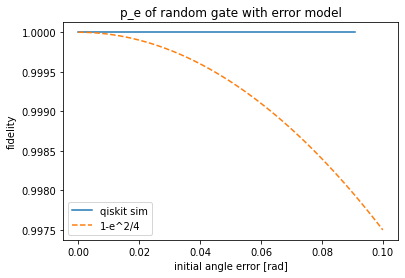

In [8]:
plt.plot(eps_vec[::10], error_model_basic, label='qiskit sim')
plt.plot(eps_vec, 1-eps_vec**2/4, '--', label='1-e^2/4')
plt.xlabel('initial angle error [rad]')
plt.ylabel('fidelity')
plt.legend()
plt.title('p_e of random gate with error model')

## State fidelity calculation with qiskit


In [9]:
def qiskit_u_err_state_tomo(epsilon, circ, err_qubit, nshots=10000):
    noise_model = NoiseModel()
    
    err_u = {}
    for gate in error_gates:
        err_c = QuantumCircuit(1)
        err_c.append(error_gates[gate].inverse(), [0])
        err_c.p(epsilon, 0)
        err_c.append(error_gates[gate], [0])
        err_c.p(-epsilon, 0)
        err_u[gate] = qi.Operator(err_c)
        noise_model.add_quantum_error(coherent_unitary_error(err_u[gate]), gate, [err_qubit])

    #print(noise_model)
    #print(circ)
    noise_sim = AerSimulator(noise_model=noise_model)
    qpt_circs = state_tomography_circuits(circ, circ.qregs)
    job = noise_sim.run(qpt_circs, shots=nshots)
    
#     if epsilon == 0:
#         for c in qpt_circs:
#             print(c.draw())

    qpt_tomo = StateTomographyFitter(job.result(), qpt_circs)
    ft = qpt_tomo.fit(method='lstsq')
    F_simp = qi.state_fidelity(ft, qi.Statevector(circ))
    #print(qi.Statevector(circ))
    return F_simp


In [10]:
# single qubit gate

circ = QuantumCircuit(1)
circ.h(0)
circ.x(0)
circ.y(0)

error_model_fidelity = [qiskit_u_err_state_tomo(eps, circ, 0) for eps in tqdm(eps_vec[::10])] 

/Users/lior/miniconda3/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
/Users/lior/miniconda3/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/Users/lior/miniconda3/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
/Users/lior/mini

Text(0.5, 1.0, 'qiskit state tomography analysis of initial phase error')

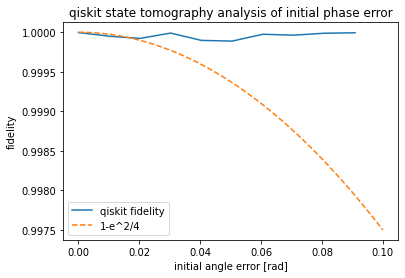

In [11]:
plt.plot(eps_vec[::10], error_model_fidelity, label='qiskit fidelity')
#plt.plot(eps_vec, error_model, label='qiskit sim')
plt.plot(eps_vec, 1-eps_vec**2/4, '--', label='1-e^2/4')
plt.xlabel('initial angle error [rad]')
plt.ylabel('fidelity')
plt.legend()
plt.title('qiskit state tomography analysis of initial phase error')

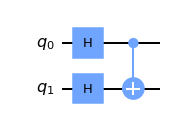

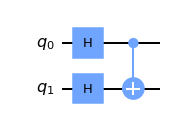

In [12]:
# two qubit gate - cx

circ = QuantumCircuit(2)
circ.h(0)
circ.h(1)
circ.cx(0, 1)
circ.draw(output='mpl')

In [13]:
error_model_fidelity_2q_err1 = [qiskit_u_err_state_tomo(eps, circ, 1) for eps in tqdm(eps_vec)]
error_model_fidelity_2q_err0 = [qiskit_u_err_state_tomo(eps, circ, 0) for eps in tqdm(eps_vec)] 

Text(0.5, 1.0, 'state tomo. fidelity for cx circuit')

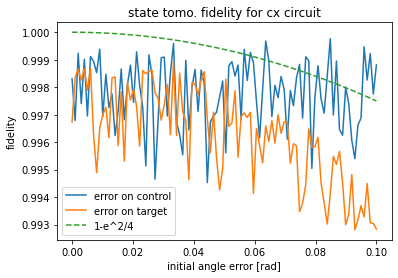

In [14]:
plt.plot(eps_vec, error_model_fidelity_2q_err0, label='error on control')
plt.plot(eps_vec, error_model_fidelity_2q_err1, label='error on target')
plt.plot(eps_vec, 1-eps_vec**2/4, '--', label='1-e^2/4')
plt.xlabel('initial angle error [rad]')
plt.ylabel('fidelity')
plt.legend()
plt.title('state tomo. fidelity for cx circuit')

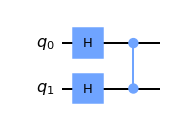

In [15]:
# two qubit gate - cz

circ = QuantumCircuit(2)
circ.h(0)
circ.h(1)
circ.cz(0, 1)
circ.draw(output='mpl')

error_model_fidelity_2q_err1 = [qiskit_u_err_state_tomo(eps, circ, 1) for eps in tqdm(eps_vec)]
error_model_fidelity_2q_err0 = [qiskit_u_err_state_tomo(eps, circ, 0) for eps in tqdm(eps_vec)] 

Text(0.5, 1.0, 'state tomo. fidelity for cz circuit')

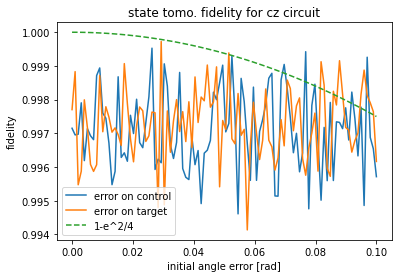

In [16]:
plt.plot(eps_vec, error_model_fidelity_2q_err0, label='error on control')
plt.plot(eps_vec, error_model_fidelity_2q_err1, label='error on target')
plt.plot(eps_vec, 1-eps_vec**2/4, '--', label='1-e^2/4')
plt.xlabel('initial angle error [rad]')
plt.ylabel('fidelity')
plt.legend()
plt.title('state tomo. fidelity for cz circuit')

## Process tomography

In [90]:
def qiskit_u_err_process_tomo(epsilon, circ, err_qubit, nshots=10000):
    noise_model = NoiseModel()
    
    err_u = {}
    for gate in error_gates:
        err_c = QuantumCircuit(1)
        err_c.append(error_gates[gate].inverse(), [0])
        err_c.p(epsilon, 0)
        err_c.append(error_gates[gate], [0])
        err_c.p(-epsilon, 0)
        err_u[gate] = qi.Operator(err_c)
        noise_model.add_quantum_error(coherent_unitary_error(err_u[gate]), gate, [err_qubit])

    #print(noise_model)
    #print(circ)
    noise_sim = AerSimulator(noise_model=noise_model)
    qpt_circs = process_tomography_circuits(circ, circ.qregs)#circ.qubits[err_qubit])
    job = noise_sim.run(qpt_circs, shots=nshots)

#     if epsilon == 0:
#         for c in qpt_circs:
#             print(c.draw())
    qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs)
    choi_fit = qpt_tomo.fit(method='lstsq')
    F_simp = qi.average_gate_fidelity(choi_fit, target=qi.Operator(circ))
    #print(qi.Statevector(circ))
    return F_simp


In [91]:
print(circ.draw())
array_to_latex(qi.Operator(circ))

     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


<IPython.core.display.Latex object>

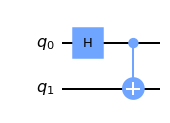

In [95]:
# two qubit gate - cz

circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.draw(output='mpl')

error_model_proc_fidelity_2q_err1 = [qiskit_u_err_process_tomo(eps, circ, 1) for eps in tqdm(eps_vec)] 

Text(0.5, 1.0, 'state process fidelity for cx circuit')

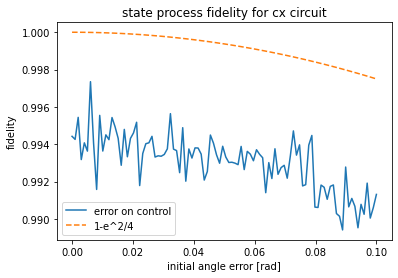

In [96]:
plt.plot(eps_vec, error_model_proc_fidelity_2q_err1, label='error on control')
#plt.plot(eps_vec, error_model_fidelity_2q_err1, label='error on target')
plt.plot(eps_vec, 1-eps_vec**2/4, '--', label='1-e^2/4')
plt.xlabel('initial angle error [rad]')
plt.ylabel('fidelity')
plt.legend()
plt.title('state process fidelity for cx circuit')